In [520]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


Os dados começaram a obter um índice adequado de preenchimento a partir de 2020. Portanto, vamos desconsiderar os anos anteriores para este projeto.

In [521]:
# Caminho para o diretório onde estão os datasets
diretorio = 'data/raw/'

# Lista para armazenar cada DataFrame
dataframes = []

# Loop através dos anos dos datasets
for ano in range(2020, 2024):
    arquivo = os.path.join(diretorio, f'acidentes_{ano}.csv')
    if os.path.exists(arquivo):
        df = pd.read_csv(arquivo, delimiter = ';')
        dataframes.append(df)
    else:
        print(f"Não foi possível encontrar o arquivo de nome: {arquivo}")

# Concatenar todos os DataFrames em um só
df_acidentes = pd.concat(dataframes, ignore_index=True)


In [522]:
df_acidentes.head(2)

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,bairro_cruzamento,num_semaforo,sentido_via,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,acidente_verificado,tempo_clima,situacao_semaforo,sinalizacao,condicao_via,conservacao_via,ponto_controle,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,Protocolo,natureza
0,2020-01-01,00:39:00,SEM VÍTIMA,CANCELADA,ÁGUA FRIA,RUA SAO SEBASTIAO,1687,NaN,EM FRENTE A IGREJA UNIVERSAL,ÁGUA FRIA,NaN,NaN,COLISÃO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,01:04:00,SEM VÍTIMA,FINALIZADA,CORDEIRO,AV CAXANGA,1444,AV GENERAL SAN MARTIN,NaN,CORDEIRO,80.0,SUBURBIO,ABALROAMENTO LONGITUDINAL,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,NaN,60 km/h,Dupla,Canteiro central,NaN,NaN,NaN,NaN


# Tipagem de dados

In [523]:
df_acidentes.dtypes

data                         object
hora                         object
natureza_acidente            object
situacao                     object
bairro                       object
endereco                     object
numero                       object
detalhe_endereco_acidente    object
complemento                  object
bairro_cruzamento            object
num_semaforo                 object
sentido_via                  object
tipo                         object
descricao                    object
auto                         object
moto                         object
ciclom                       object
ciclista                     object
pedestre                     object
onibus                       object
caminhao                     object
viatura                      object
outros                       object
vitimas                      object
vitimasfatais                object
acidente_verificado          object
tempo_clima                  object
situacao_semaforo           

### O que podemos observar?

A tipagem não está bem definida, com quase todos os campos com tipo " object ". Podemos utilizar os metadados que obtivemos junto com o dataset para mapear e corrigir a tipagem. 


In [524]:
#tratando possíveis erros na tipagem dos dados a partir dos metadados existentes.

def ajustar_tipos(df, tipos):
    for coluna, tipo in tipos.items():
        if coluna in df.columns:
            if tipo == 'datetime64':
                df[coluna] = pd.to_datetime(df[coluna], errors='coerce')  # Converte para datetime, erro se falhar
            elif tipo == 'float64' or tipo == float:
                # Antes de converter para float, remove espaços, substitui vírgulas por pontos e trata erros
                df[coluna] = df[coluna].apply(lambda x: str(x).strip().replace(',', '.')).astype(float)
            #elif coluna == 'hora' and tipo == 'hora':
                # Convertendo a string de hora para tipo de hora pandas, manipulando erros
                #df[coluna] = pd.to_datetime(df[coluna], format='%H:%M:%S', errors='coerce').dt.time
            else:
                df[coluna] = df[coluna].astype(tipo)  # Aplica outros tipos conforme especificado


tipo_de_dados = {
    'tipo': str,
    'situacao': str,
    'data': 'datetime64',
    #'hora': 'hora',
    'bairro': str,
    'endereco': str,
    'complemento': str,
    'natureza': str,
    'descricao': str,
    'auto': float,
    'moto': float,
    'ciclom': float,
    'ciclista': float,
    'pedestre': float,
    'onibus': float,
    'caminhao': float,
    'viatura': float,
    'outros': float,
    'vitimas': float,
    'vitimasfatais': float
}

# Suponha que df_acidentes seja o DataFrame que você está utilizando
ajustar_tipos(df_acidentes, tipo_de_dados)


In [525]:
df_acidentes.dtypes

data                         datetime64[ns]
hora                                 object
natureza_acidente                    object
situacao                             object
bairro                               object
endereco                             object
numero                               object
detalhe_endereco_acidente            object
complemento                          object
bairro_cruzamento                    object
num_semaforo                         object
sentido_via                          object
tipo                                 object
descricao                            object
auto                                float64
moto                                float64
ciclom                              float64
ciclista                            float64
pedestre                            float64
onibus                              float64
caminhao                            float64
viatura                             float64
outros                          

In [526]:
df_acidentes.describe()

,data,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais
count,40540,40100.000000,38308.000000,36635.000000,36768.000000,36771.000000,37107.000000,36911.000000,36688.000000,36676.000000,40694.000000,36637.000000
mean,2023-01-05 23:58:13.438579200,0.364040,0.220058,0.001720,0.016482,0.021484,0.030668,0.027986,0.014800,0.003681,0.262373,0.002921
min,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-01-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-05-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-09-15 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-12-31 00:00:00,9.000000,8.000000,1.000000,3.000000,5.000000,3.000000,15.000000,11.000000,12.000000,21.000000,6.000000
std,NaN,0.645533,0.457814,0.041434,0.129439,0.154264,0.177350,0.191819,0.134428,0.094930,0.549330,0.064133


In [527]:
df_acidentes.head(10)

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,bairro_cruzamento,num_semaforo,sentido_via,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,acidente_verificado,tempo_clima,situacao_semaforo,sinalizacao,condicao_via,conservacao_via,ponto_controle,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,Protocolo,natureza
0,2020-01-01,00:39:00,SEM VÍTIMA,CANCELADA,ÁGUA FRIA,RUA SAO SEBASTIAO,1687,NaN,EM FRENTE A IGREJA UNIVERSAL,ÁGUA FRIA,NaN,NaN,COLISÃO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,2020-01-01,01:04:00,SEM VÍTIMA,FINALIZADA,CORDEIRO,AV CAXANGA,1444,AV GENERAL SAN MARTIN,nan,CORDEIRO,80.0,SUBURBIO,ABALROAMENTO LONGITUDINAL,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,NaN,60 km/h,Dupla,Canteiro central,NaN,NaN,NaN,nan
2,2020-01-01,02:16:00,SEM VÍTIMA,FINALIZADA,AREIAS,AV RECIFE,NaN,NaN,LADO OPOSTO AO RESIDENCIAL IGNEZ ANDREAZZA,AREIAS,494.0,SUBURBIO,CHOQUE VEÍCULO PARADO,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Longo da via,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,Não há placas,NaN,Dupla,Canteiro central,NaN,NaN,NaN,nan
3,2020-01-01,02:22:00,SEM VÍTIMA,FINALIZADA,BOA VIAGEM,AV BOA VIAGEM,NaN,NaN,EM FRENTE AO 1º JARDIM B. VIAGEM,BOA VIAGEM,NaN,CIDADE,COLISÃO TRASEIRA,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Longo da via,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,R-6a,NaN,Única,Faixa seccionada,NaN,NaN,NaN,nan
4,2020-01-01,03:33:00,SEM VÍTIMA,FINALIZADA,PAISSANDU,AV GOVERNADOR AGAMENON MAGALHAES,NaN,NaN,CAIXA ECONÔMICA FEDERAL ILHA DO LEITE,PAISSANDU,672.0,SUBURBIO,ABALROAMENTO TRANSVERSAL,COLISÃOENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,Não há placas,NaN,Única,Faixa contínua,Faixa seccionada,Canteiro central,NaN,nan
5,2020-01-01,04:18:00,SEM VÍTIMA,FINALIZADA,BARRO,AV DR JOSE RUFINO,NaN,NaN,nan,BARRO,NaN,SUBURBIO,COLISÃO TRASEIRA,COLISÃO ENTRE DOIS AUTOS S/V,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Longo da via,Bom,Não existe,Ilegível,Seca,Mal conservada,Não existe,Não há placas,NaN,Dupla,Faixa seccionada,NaN,NaN,NaN,nan
6,2020-01-01,04:47:00,SEM VÍTIMA,FINALIZADA,PINA,AV CONSELHEIRO AGUIAR,NaN,AV HERCULANO BANDEIRA,nan,PINA,138.0,NaN,CHOQUE OBJETO FIXO,AUTO CHOCOU-SE EM MURO DE UMA RESIDENCIA E EM ...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Cruzamento,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,R-6a,NaN,Única,Faixa seccionada,NaN,NaN,NaN,nan
7,2020-01-01,09:06:00,COM VÍTIMA,FINALIZADA,PINA,AVENIDA CELSO FURTADO (VIA MANGUE),NaN,NaN,PROX: SHOPPING RIO MAR . ULTIMA CURVA ANTES DO...,PINA,NaN,BOA VIAGEM,CHOQUE OBJETO FIXO,COLISAO COM DUAS VITIMA. MOTO COM GLADIO DA VIA,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,Longo da via,Bom,Não existe,Perfeito estado,Seca,Perfeito estado,NaN,Não há placas,60 km/h,Dupla,Faixa seccionada,NaN,NaN,NaN,nan
8,2020-01-01,10:07:00,COM VÍTIMA,FINALIZADA,MADALENA,EST DOS REMEDIOS,2328,NaN,LADO OPOSTO AO LESSA DE ANDRADE,MADALENA,NaN,SUBURBIO,CHOQUE OBJETO FIXO,PEGEOUT SE CHOCOU COM POSTE E COM O GRADIL DA ...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,Longo da via,Bom,Sem defeito,Perfeito estado,Seca,Perfeito estado,Faixa de pedestre,Placas Pare,NaN,Única,Faixa seccionada,NaN,NaN,NaN,nan
9,2020-01-01,12:09:00,SEM VÍTIMA,FINALIZADA,NOVA DESCOBERTA,RUA NOVA DESCOBERTA,1335,NaN,nan,NOVA DESCOBERTA,NaN,CIDADE,CHOQUE VEÍCULO PARADO,COLISÃO SEM VÍTIMA,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,Longo da via,Bom,Não existe,Perfeito estado,Seca,Perfeito estado,Não existe,Não há placas,NaN,Dupla,Faixa seccionada,Na

# Tratamento de Dados Ausentes

In [528]:
#analisando quantidades de nulos

nulos_por_coluna = df_acidentes.isnull().sum()
print(nulos_por_coluna)

data                           168
hora                          2837
natureza_acidente            34237
situacao                         0
bairro                           0
endereco                         0
numero                       24311
detalhe_endereco_acidente    30375
complemento                      0
bairro_cruzamento              148
num_semaforo                 37109
sentido_via                  33264
tipo                             0
descricao                        0
auto                           608
moto                          2400
ciclom                        4073
ciclista                      3940
pedestre                      3937
onibus                        3601
caminhao                      3797
viatura                       4020
outros                        4032
vitimas                         14
vitimasfatais                 4071
acidente_verificado          33541
tempo_clima                  33424
situacao_semaforo            33513
sinalizacao         

In [529]:
#Percentual de nulos

percentual_nulos = (df_acidentes.isnull().sum() / len(df_acidentes)) * 100
print(percentual_nulos)

data                          0.412695
hora                          6.969146
natureza_acidente            84.103862
situacao                      0.000000
bairro                        0.000000
endereco                      0.000000
numero                       59.720448
detalhe_endereco_acidente    74.616783
complemento                   0.000000
bairro_cruzamento             0.363565
num_semaforo                 91.158986
sentido_via                  81.713668
tipo                          0.000000
descricao                     0.000000
auto                          1.493564
moto                          5.895647
ciclom                       10.005404
ciclista                      9.678687
pedestre                      9.671318
onibus                        8.845927
caminhao                      9.327405
viatura                       9.875209
outros                        9.904687
vitimas                       0.034391
vitimasfatais                10.000491
acidente_verificado      

#### Preenchimento da coluna natureza_acidente

Note que a coluna de natureza_acidente possui um índice de nulos muito elevado, mas é possível realizar o preenchimento a partir das colunas que representam as vítimas e as vítimas fatais. Essa coluna categória é muito importante para as análises que realizaremos posteriormente.

In [530]:
def classificar_acidente(row):
    if row['vitimasfatais'] > 0:
        return 'Fatal'
    elif row['vitimas'] > 0:
        return 'Não fatal'
    else:
        return 'Sem vítimas'

df_acidentes['natureza_acidente'] = df_acidentes.apply(classificar_acidente, axis=1)

#### Remoção de colunas

É possível observar que o percentual de nulos em algumas colunas do dataframe é muito alto. Realizaremos um recorte das colunas que possuem quantidade de nulos maior que 25% para trabalharmos com dados mais consistentes.

In [531]:
# Removendo colunas com índice de nulos maior que 25%:

df_acidentes = df_acidentes.loc[:, df_acidentes.isnull().sum() / len(df_acidentes) < 0.25]


In [532]:
percentual_nulos = (df_acidentes.isnull().sum() / len(df_acidentes)) * 100
print(percentual_nulos)

data                  0.412695
hora                  6.969146
natureza_acidente     0.000000
situacao              0.000000
bairro                0.000000
endereco              0.000000
complemento           0.000000
bairro_cruzamento     0.363565
tipo                  0.000000
descricao             0.000000
auto                  1.493564
moto                  5.895647
ciclom               10.005404
ciclista              9.678687
pedestre              9.671318
onibus                8.845927
caminhao              9.327405
viatura               9.875209
outros                9.904687
vitimas               0.034391
vitimasfatais        10.000491
Protocolo            15.901051
natureza              0.000000
dtype: float64


In [533]:
#aproveitamos esse momento para remover a coluna "natureza", que não possui utilidade para nós.

df_acidentes = df_acidentes.drop('natureza', axis=1)


# Normalização e Discretização

In [534]:
# Normalização
df_acidentes_normalizado = df_acidentes.copy()

scaler = MinMaxScaler()
numeric_cols = df_acidentes_normalizado.select_dtypes(include=['int64', 'float64']).columns

df_acidentes_normalizado[numeric_cols] = scaler.fit_transform(df_acidentes_normalizado[numeric_cols])




In [535]:
df_acidentes_normalizado.head()

,data,hora,natureza_acidente,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,Protocolo
0,2020-01-01,00:39:00,Sem vítimas,CANCELADA,ÁGUA FRIA,RUA SAO SEBASTIAO,EM FRENTE A IGREJA UNIVERSAL,ÁGUA FRIA,COLISÃO,COLISÃO ENTRE DOIS AUTOS S/V,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,2020-01-01,01:04:00,Sem vítimas,FINALIZADA,CORDEIRO,AV CAXANGA,nan,CORDEIRO,ABALROAMENTO LONGITUDINAL,COLISÃO ENTRE DOIS AUTOS S/V,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2020-01-01,02:16:00,Sem vítimas,FINALIZADA,AREIAS,AV RECIFE,LADO OPOSTO AO RESIDENCIAL IGNEZ ANDREAZZA,AREIAS,CHOQUE VEÍCULO PARADO,COLISÃO ENTRE DOIS AUTOS S/V,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2020-01-01,02:22:00,Sem vítimas,FINALIZADA,BOA VIAGEM,AV BOA VIAGEM,EM FRENTE AO 1º JARDIM B. VIAGEM,BOA VIAGEM,COLISÃO TRASEIRA,COLISÃO ENTRE DOIS AUTOS S/V,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2020-01-01,03:33:00,Sem vítimas,FINALIZADA,PAISSANDU,AV GOVERNADOR AGAMENON MAGALHAES,CAIXA ECONÔMICA FEDERAL ILHA DO LEITE,PAISSANDU,ABALROAMENTO TRANSVERSAL,COLISÃOENTRE DOIS AUTOS S/V,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [536]:
df_acidentes_normalizado.describe()

,data,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais
count,40540,40100.000000,38308.000000,36635.000000,36768.000000,36771.000000,37107.000000,36911.000000,36688.000000,36676.000000,40694.000000,36637.000000
mean,2023-01-05 23:58:13.438579200,0.040449,0.027507,0.001720,0.005494,0.004297,0.010223,0.001866,0.001345,0.000307,0.012494,0.000487
min,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-01-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-05-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-09-15 00:00:00,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-12-31 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.071726,0.057227,0.041434,0.043146,0.030853,0.059117,0.012788,0.012221,0.007911,0.026159,0.010689


In [537]:
# Discretização

df_acidentes_discretizado = df_acidentes.copy()

numeric_cols = df_acidentes_discretizado.select_dtypes(include=['int64', 'float64']).columns


df_acidentes_discretizado_clean = df_acidentes_discretizado.dropna(subset=numeric_cols)

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Ajustando e transformando os dados
discretized_data = discretizer.fit_transform(df_acidentes_discretizado_clean[numeric_cols])
df = pd.DataFrame(discretized_data, columns=[col + '_bin' for col in numeric_cols])
df_acidentes_discretizado = pd.concat([df_acidentes_discretizado_clean.reset_index(drop=True), df], axis=1)
#Removendo colunas originais após discretização:
df_acidentes_discretizado = df_acidentes_discretizado.drop(columns=numeric_cols)

In [538]:
df_acidentes_discretizado.head()

,data,hora,natureza_acidente,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,Protocolo,auto_bin,moto_bin,ciclom_bin,ciclista_bin,pedestre_bin,onibus_bin,caminhao_bin,viatura_bin,outros_bin,vitimas_bin,vitimasfatais_bin
0,2021-01-01,19:44:00,Não fatal,FINALIZADA,MADALENA,RUA BENFICA,EM FRENTE AO EXTRA NA SAIDA,MADALENA,COLISÃO FRONTAL,nan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01,23:15:40,Não fatal,FINALIZADA,VÁRZEA,AV CAXANGA,EM FRENTE A UPA DA CAXANGA,VÁRZEA,COLISÃO TRASEIRA,nan,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-02,10:54:00,Não fatal,FINALIZADA,VASCO DA GAMA,RUA RESPLENDOR,AO LADO DO COLEGIO ADERBAL GALVÃO EM FRE...,VASCO DA GAMA,COLISÃO COM CICLISTA,nan,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-02,11:13:00,Não fatal,FINALIZADA,BOA VIAGEM,RUA VISCONDE DE JEQUITINHONHA,RUA CAPITÃO ZUZINHA,BOA VIAGEM,COLISÃO LATERAL,nan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-03,09:32:00,Não fatal,FINALIZADA,ILHA DO RETIRO,AV ENGENHEIRO ABDIAS DE CARVALHO,EM FRENTE A LANCHONETE COXINHAS DE BATATA,ILHA DO RETIRO,COLISÃO LATERAL,nan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [539]:
df_acidentes_discretizado.describe()

,data,auto_bin,moto_bin,ciclom_bin,ciclista_bin,pedestre_bin,onibus_bin,caminhao_bin,viatura_bin,outros_bin,vitimas_bin,vitimasfatais_bin
count,36448,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000
mean,2023-04-25 14:22:30.395083264,0.034083,0.013819,0.004807,0.012508,0.017561,0.034848,0.000273,0.000109,0.000191,0.000437,0.000218
min,2021-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-02-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-06-11 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-09-27 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-12-31 00:00:00,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
std,NaN,0.189400,0.119744,0.138578,0.116186,0.146674,0.270722,0.024511,0.020904,0.026129,0.033866,0.026647


# Limpeza de dados

### Análise de duplicatas

In [540]:
duplicatas = df_acidentes.duplicated(keep=False)

numero_duplicatas = duplicatas.sum()

# Mostrar o número de duplicatas
print(f'Número de registros duplicados existentes: {numero_duplicatas}')



Número de registros duplicados existentes: 2


In [541]:
df_acidentes[duplicatas].head(10)

,data,hora,natureza_acidente,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,Protocolo
4704,2021-04-10,16:36:00,Sem vítimas,FINALIZADA,DERBY,AV GOVERNADOR AGAMENON MAGALHAES,nan,DERBY,SEMÁFORO,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4705,2021-04-10,16:36:00,Sem vítimas,FINALIZADA,DERBY,AV GOVERNADOR AGAMENON MAGALHAES,nan,DERBY,SEMÁFORO,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [542]:
df_acidentes = df_acidentes.drop_duplicates()

In [543]:
df_acidentes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40707 entries, 0 to 40707
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               40539 non-null  datetime64[ns]
 1   hora               37870 non-null  object        
 2   natureza_acidente  40707 non-null  object        
 3   situacao           40707 non-null  object        
 4   bairro             40707 non-null  object        
 5   endereco           40707 non-null  object        
 6   complemento        40707 non-null  object        
 7   bairro_cruzamento  40559 non-null  object        
 8   tipo               40707 non-null  object        
 9   descricao          40707 non-null  object        
 10  auto               40099 non-null  float64       
 11  moto               38307 non-null  float64       
 12  ciclom             36634 non-null  float64       
 13  ciclista           36767 non-null  float64       
 14  pedestre   

# Análise de dados

moto - Outliers identificados: 7759
Limite Inferior para moto: 0.0, Limite Superior para moto: 0.0
auto - Outliers identificados: 348
Limite Inferior para auto: -1.5, Limite Superior para auto: 2.5
vitimas - Outliers identificados: 9153
Limite Inferior para vitimas: 0.0, Limite Superior para vitimas: 0.0


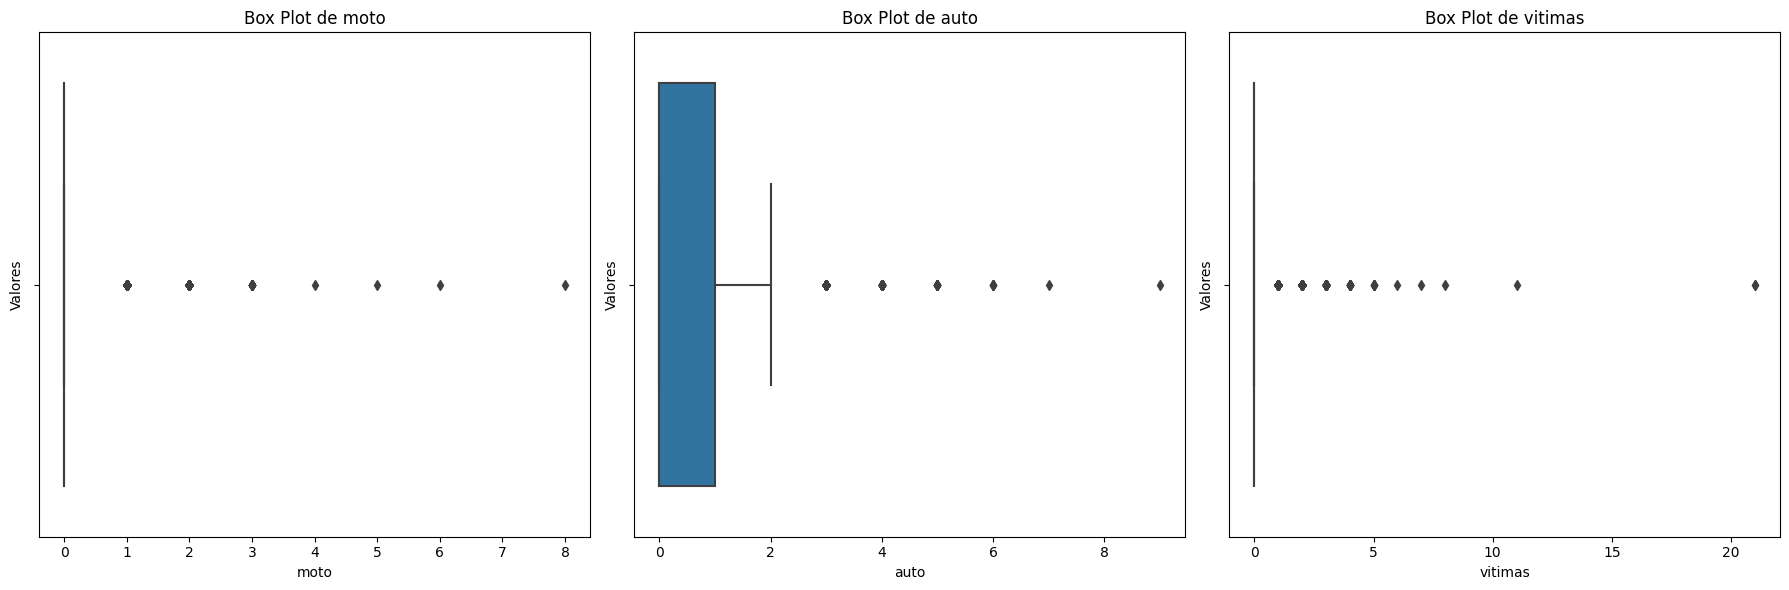

In [544]:
# Lista das variáveis mais importantes
important_vars = ['moto', 'auto', 'vitimas']

fig, axes = plt.subplots(nrows=1, ncols=len(important_vars), figsize=(18, 6))

# Loop pelas variáveis importantes para aplicar o método de Tukey
for i, var in enumerate(important_vars):
    Q1 = df_acidentes[var].quantile(0.25)
    Q3 = df_acidentes[var].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definindo os limites para considerar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificando os outliers
    outliers = df_acidentes[(df_acidentes[var] < lower_bound) | (df_acidentes[var] > upper_bound)]
    
    print(f"{var} - Outliers identificados: {len(outliers)}")
    print(f"Limite Inferior para {var}: {lower_bound}, Limite Superior para {var}: {upper_bound}")

    # Plotando box plot para cada variável
    sns.boxplot(x=df_acidentes[var], ax=axes[i])
    axes[i].set_title(f'Box Plot de {var}')
    axes[i].set_xlabel(f'{var}')
    axes[i].set_ylabel('Valores')

# Ajustar layout
plt.tight_layout()
plt.show()


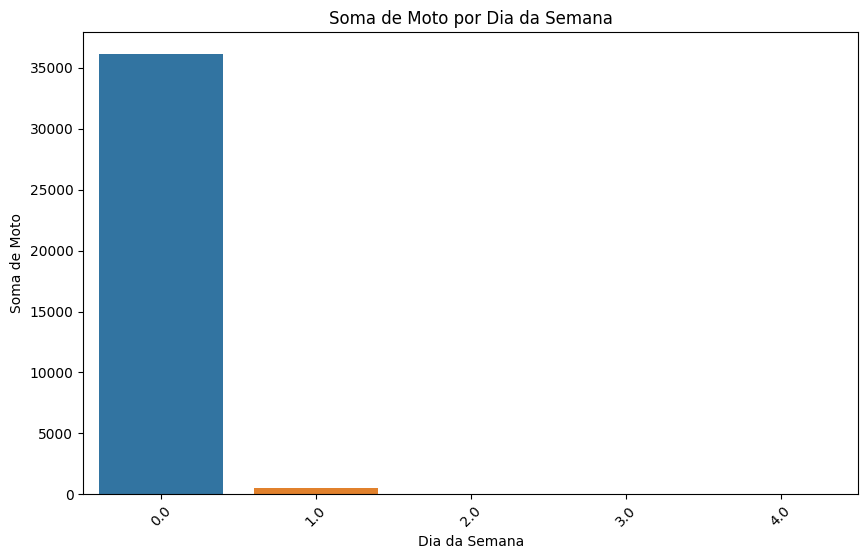

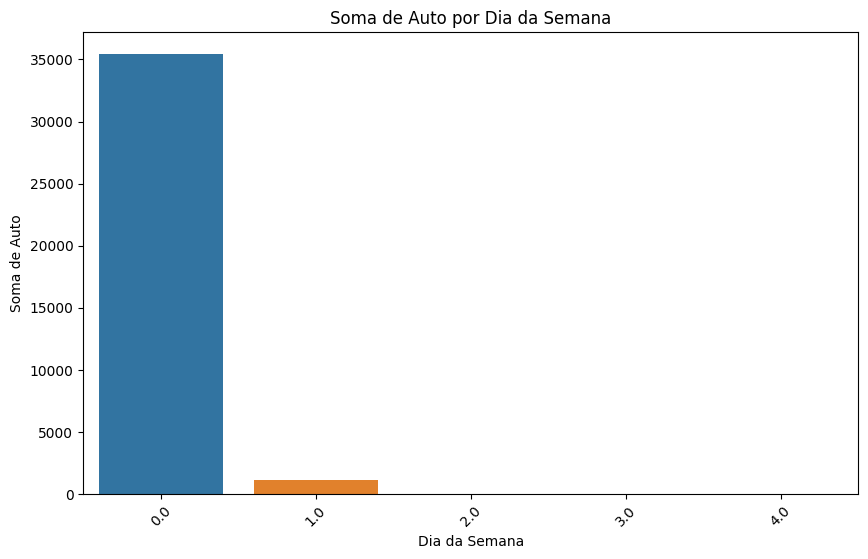

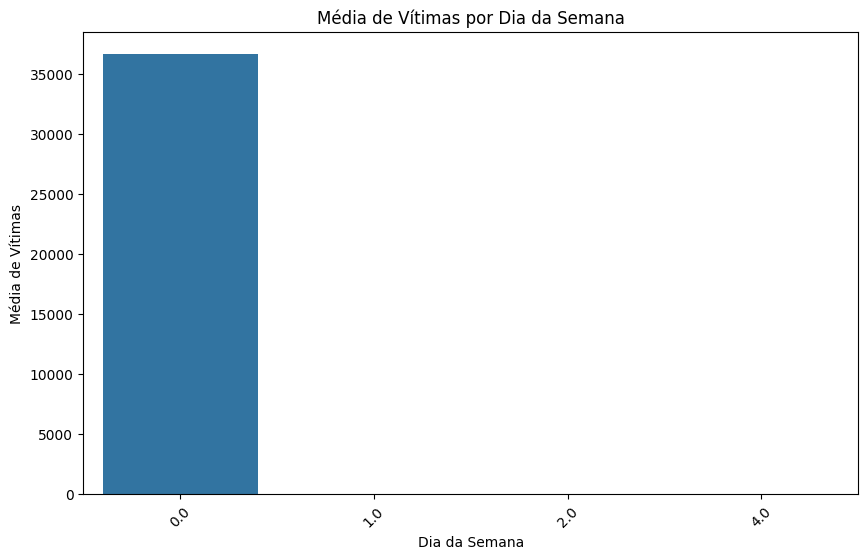

In [545]:
plt.figure(figsize=(10, 6))
sns.countplot(x='moto_bin', data=df_acidentes_discretizado)
plt.title('Soma de Moto por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Soma de Moto')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='auto_bin', data=df_acidentes_discretizado)
plt.title('Soma de Auto por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Soma de Auto')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='vitimas_bin', data=df_acidentes_discretizado)
plt.title('Média de Vítimas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Média de Vítimas')
plt.xticks(rotation=45)
plt.show()

<Axes: >

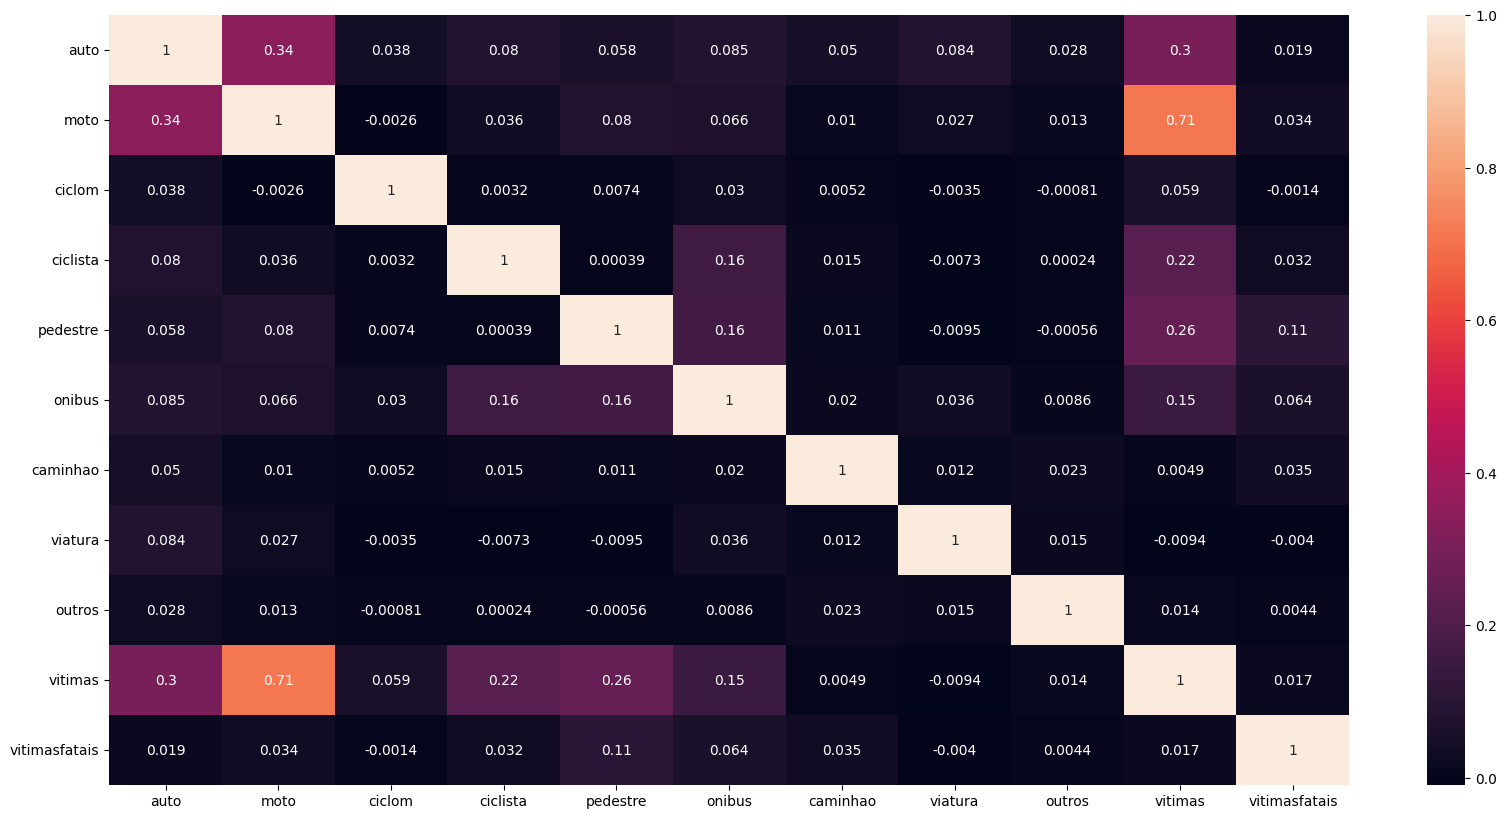

In [546]:
# Análise Bivariada
# Correlação entre variáveis
plt.figure(figsize=(20,10))
df_numeric = df_acidentes.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True)

Vítimas e Moto: Existe uma correlação relativamente forte (aproximadamente 0.71) entre motocicletas (moto) e vítimas não fatais (vitimas). Isso indica que acidentes envolvendo motocicletas têm uma tendência maior de resultar em vítimas não fatais.



In [547]:
#adicionar multivariado com número de carros e motos no acidente, no peso de cada ponto colocar número de vítimas fatais

# Enriquecimento de Dados

Essa é uma etapa extra, mas acredito que seja interessante enriquecer nosso dataset ao adicionarmos informações que podem ser inferidas. O objetivo é facilitar possíveis filtros e agregações de dados.

In [548]:
# Enriquecimento envolvendo características de data e hora. 

def get_season(month):
    if month in [12, 1, 2]:
        return 'Verão'
    elif month in [3, 4, 5]:
        return 'Outono'
    elif month in [6, 7, 8]:
        return 'Inverno'
    elif month in [9, 10, 11]:
        return 'Primavera'




df_acidentes['dia_da_semana'] = df_acidentes['data'].dt.day_name()
df_acidentes['mes'] = df_acidentes['data'].dt.month
df_acidentes['ano'] = df_acidentes['data'].dt.year
df_acidentes['estacao'] = df_acidentes['data'].dt.month.apply(get_season)

# Exportação do dataset refinado.

In [549]:
nome_arquivo = 'acidentes_recife'
df_acidentes.to_csv(f'data/refined/{nome_arquivo}.csv', sep = ',')